In [1]:
#setup
data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index = 'SBBBBBSB'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
sc.stop()

NameError: name 'sc' is not defined

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init("C:\opt\spark")

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [11]:
STAT['TMIN']['eigval']

array([ -3.41784835e+04,   4.09377287e+04,   3.76750534e+04,
         3.38151423e+04,   3.17791357e+04,   2.90934500e+04,
         2.79340237e+04,   2.68580957e+04,   2.55786874e+04,
         2.42423409e+04,   2.32696767e+04,   2.11197600e+04,
         2.22035031e+04,   2.22254663e+04,  -1.77345803e+04,
        -1.48172476e+04,  -1.10727827e+04,  -1.00400212e+04,
         1.98595645e+04,   1.95481138e+04,   1.92674333e+04,
         1.81277544e+04,  -8.47470280e+03,   1.74974396e+04,
        -7.66547991e+03,   1.71138819e+04,   1.59491169e+04,
         1.56169162e+04,   1.51943653e+04,   1.46278826e+04,
         1.40716756e+04,   1.36561651e+04,   1.34119566e+04,
         1.28916769e+04,   1.25864328e+04,   1.20742875e+04,
         1.16866000e+04,   1.13934821e+04,   1.11269700e+04,
         1.08724891e+04,   1.06925261e+04,   1.02347420e+04,
         9.91478292e+03,   9.86635832e+03,   9.61030716e+03,
         9.41620875e+03,   8.86497312e+03,   8.79651352e+03,
        -5.59849646e+03,

## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [61]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    482.0|    49.3|   -99.45|       SNWD|CA005010191|     0|[80 5F D0 5F 88 6...|2004.0|SBBBBBSB|
|    482.0|    49.3|   -99.45|       SNWD|CA005010191|    19|[00 7E C4 60 00 7...|2009.0|SBBBBBSB|
|    482.0|    49.3|   -99.45|       SNWD|CA005010191|     0|[24 60 24 60 24 6...|2010.0|SBBBBBSB|
|    482.0|    49.3|   -99.45|       SNWD|CA005010191|     0|[1C 63 1C 63 1C 6...|2011.0|SBBBBBSB|
|    482.0|    49.3|   -99.45|       SNWD|CA005010191|     7|[60 54 60 54 60 5...|2012.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

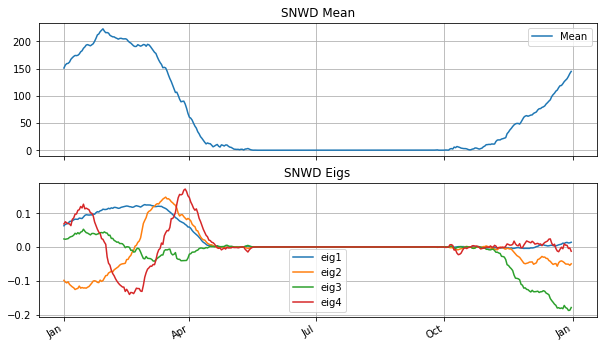

In [62]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [9]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

In [63]:
file_index

'SBBBBBSB'

### plot the percent of residual variance on average

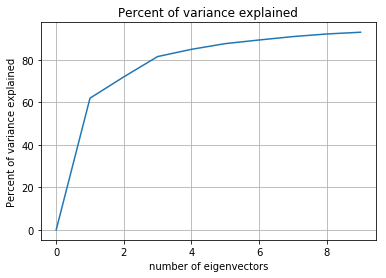

In [10]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [11]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [12]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1122
after filter 798


In [13]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [48]:
def plot_decomp(row,Mean,v,coeff_val,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='Coeff %s=%s Residual %s = %s'%(str(coeff_val), row['coeff_'+str(coeff_val)], str(coeff_val), row['res_'+str(coeff_val)])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,coeff_val,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,coeff_val,fig=fig,ax=axes[i,j],interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [15]:
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
rows=df4.take(12)
df4.select('coeff_2','res_2').show(4)

+-------------------+-------------------+
|            coeff_2|              res_2|
+-------------------+-------------------+
|-2474.3438377633706|0.15226203263922217|
|-2131.9917424015266| 0.0972204523308136|
|-2038.9515394964449|0.37218331706527996|
|-1940.8203460728232|0.11861822076519021|
+-------------------+-------------------+
only showing top 4 rows



C:\Users\Sudarshan\Anaconda3\envs\py2\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


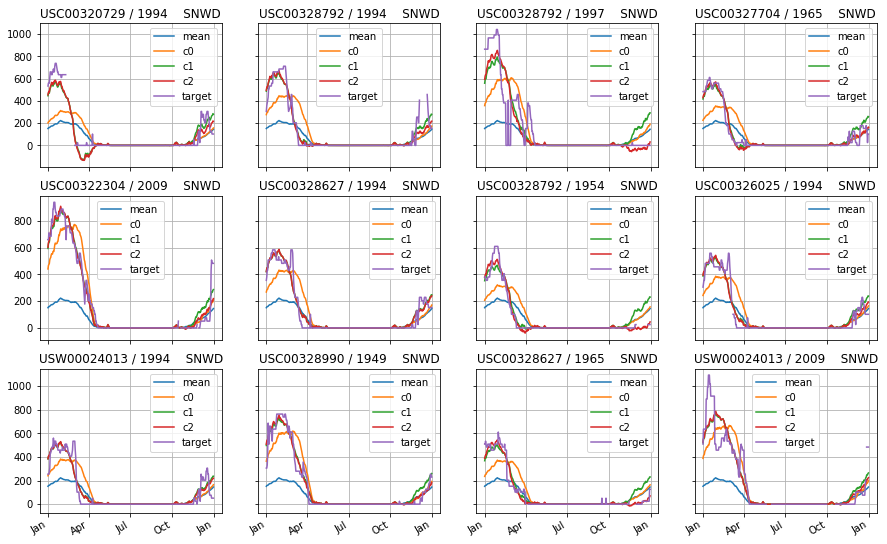

In [16]:
plot_recon_grid(rows)

In [17]:
df3.sort?

In [44]:
df5 = df3.sort(df3.coeff_1,ascending = False)
rows_c1 = df5.take(6)
df5.select('coeff_1','res_1').show(4)


+------------------+--------------------+
|           coeff_1|               res_1|
+------------------+--------------------+
| 10654.43723501594|0.023861957275659033|
| 7847.697671352092|0.040422302278396015|
|6353.6998481187875| 0.03084589624537188|
| 5497.052338742258|0.023803226137587914|
+------------------+--------------------+
only showing top 4 rows



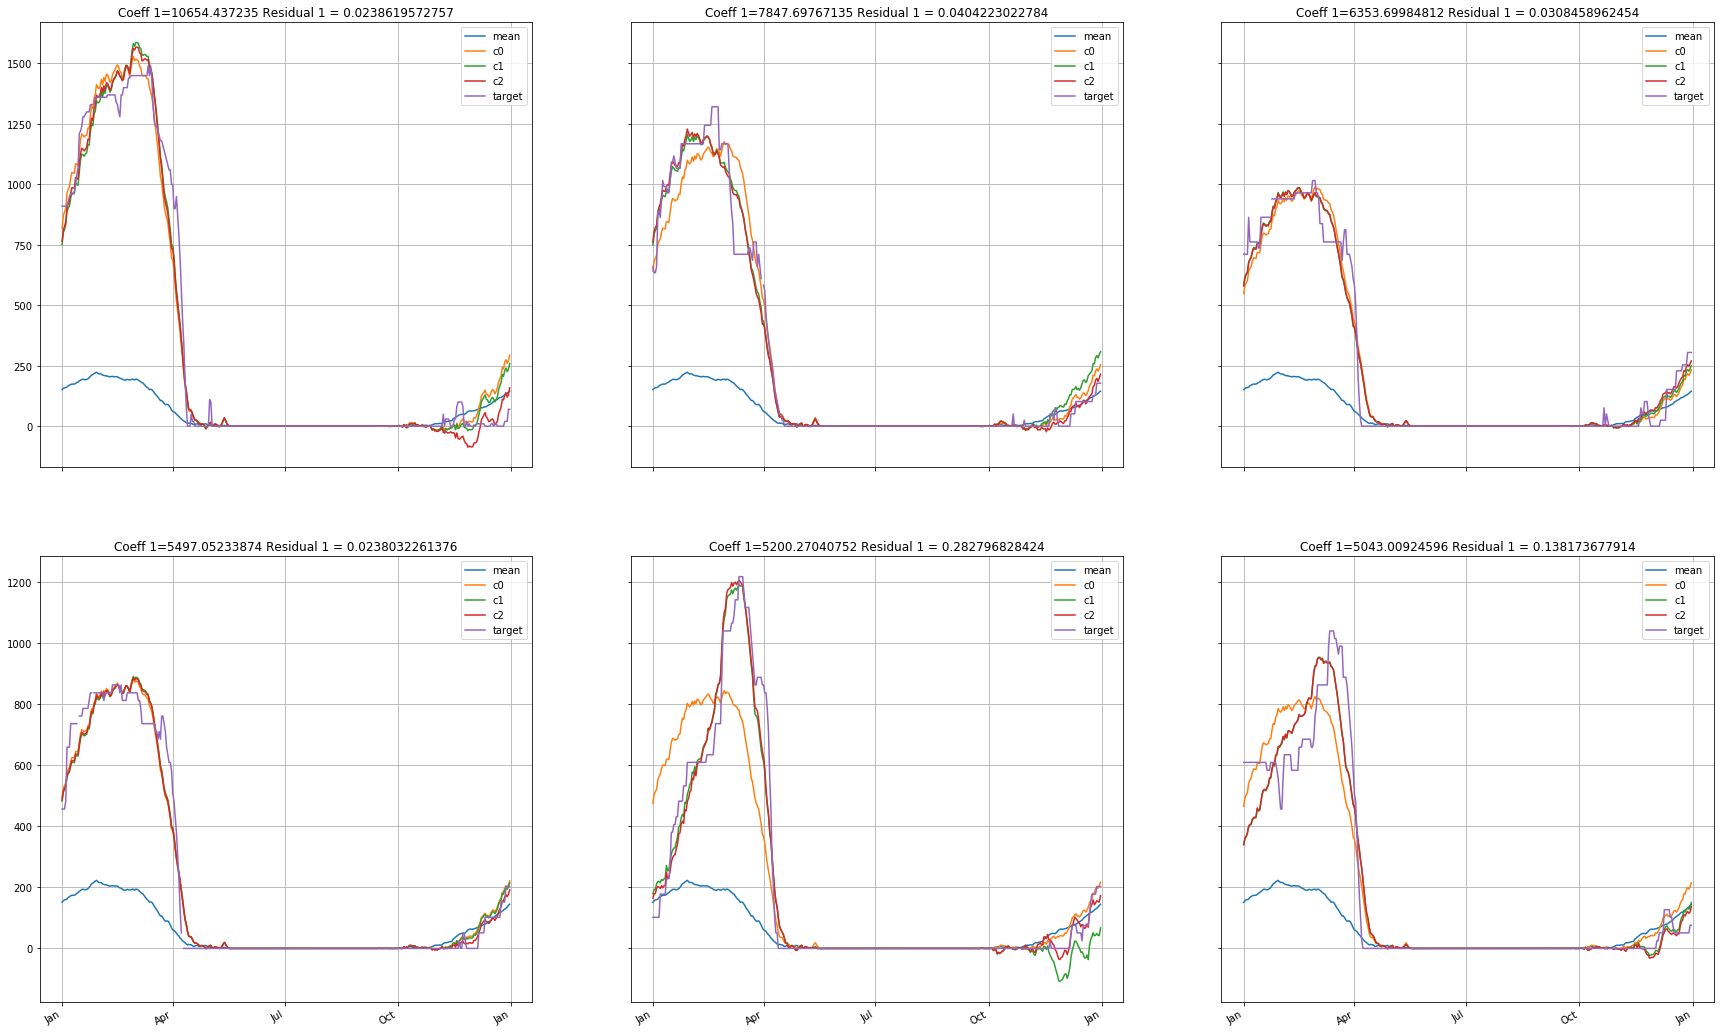

In [49]:
plot_recon_grid(rows_c1,1,row_n=2,column_n=3,figsize=[30,20])

In [40]:
df6 = df3.sort(df3.coeff_1)
rows_c1_asc = df6.take(6)
df6.select('coeff_1','res_1').show(4)

+-------------------+------------------+
|            coeff_1|             res_1|
+-------------------+------------------+
|-1501.4376472256627| 0.695211251927066|
|-1356.3903430604346|0.6791598103102549|
|-1303.6264144122647|0.5234168644785294|
|-1302.1613782007307|0.4722099403989875|
+-------------------+------------------+
only showing top 4 rows



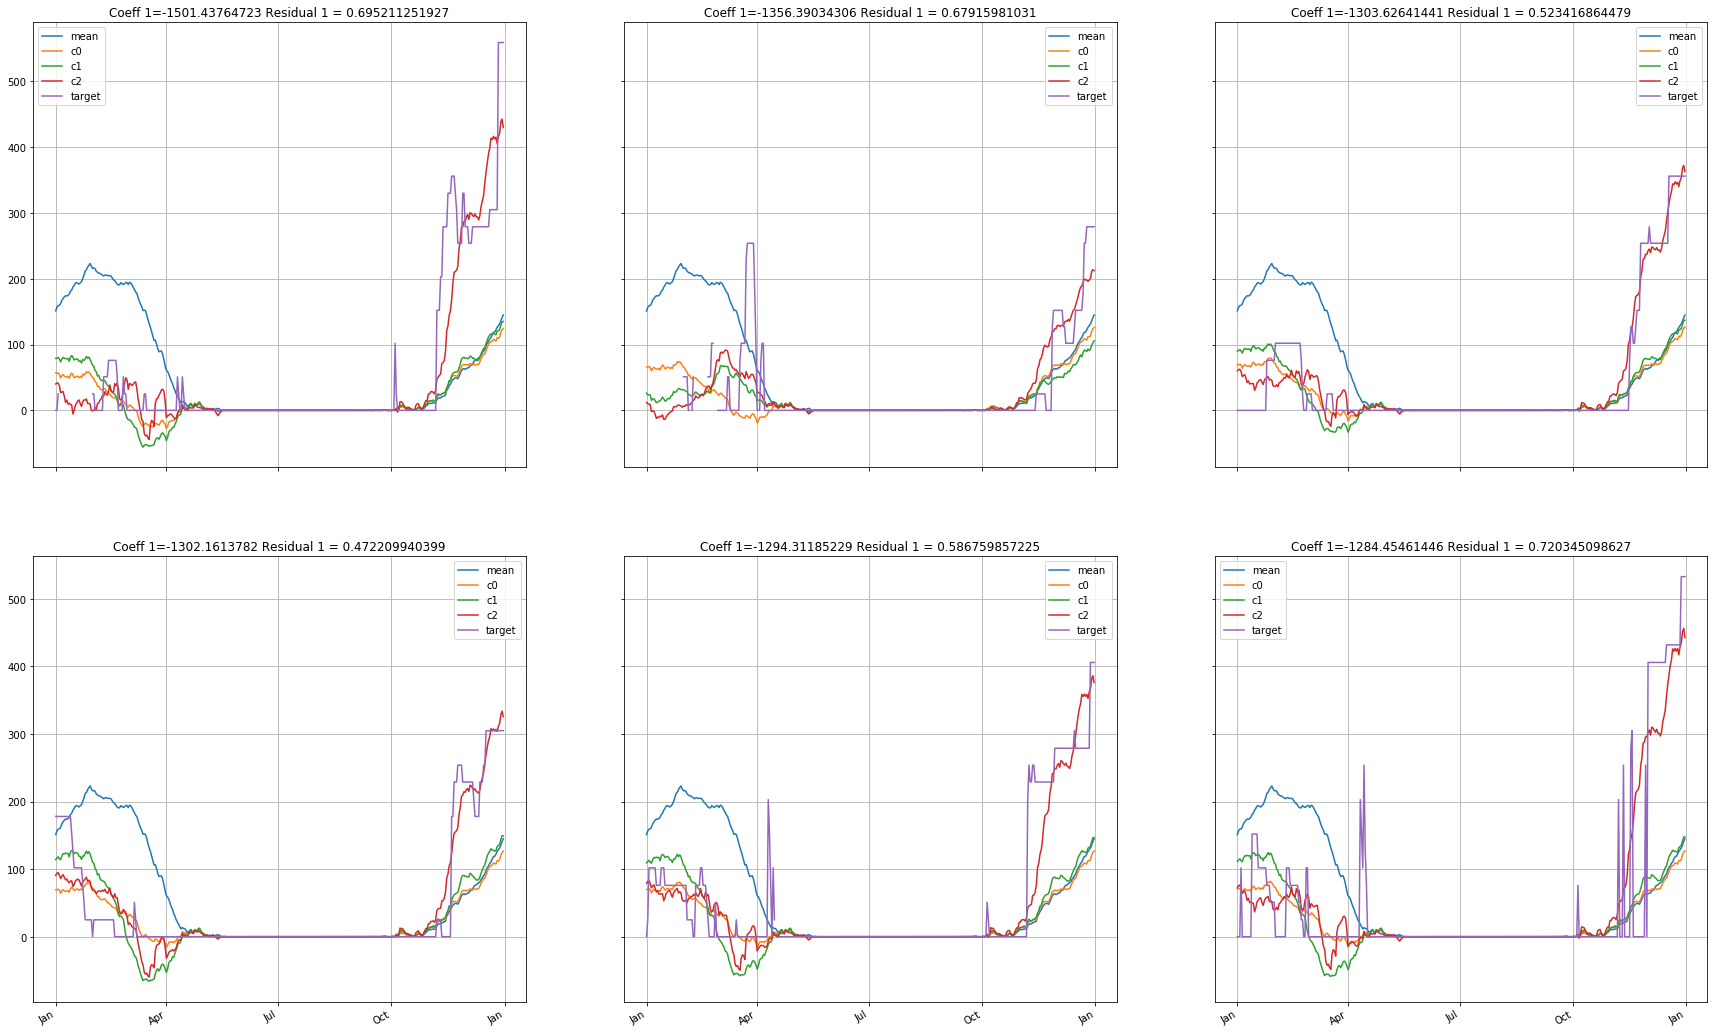

In [51]:
plot_recon_grid(rows_c1_asc,1,row_n=2,column_n=3,figsize=[30,20])

+------------------+--------------------+
|           coeff_2|               res_2|
+------------------+--------------------+
| 3012.272382683788| 0.04215072849443428|
| 2332.762321492246| 0.02830714172479206|
|2273.9292511501853| 0.43606160753855105|
| 2030.489756380516|0.028668264734965598|
+------------------+--------------------+
only showing top 4 rows



C:\Users\Sudarshan\Anaconda3\envs\py2\lib\site-packages\matplotlib\transforms.py:661: RuntimeWarning: invalid value encountered in absolute
  inside = ((abs(dx0 + dx1) + abs(dy0 + dy1)) == 0)


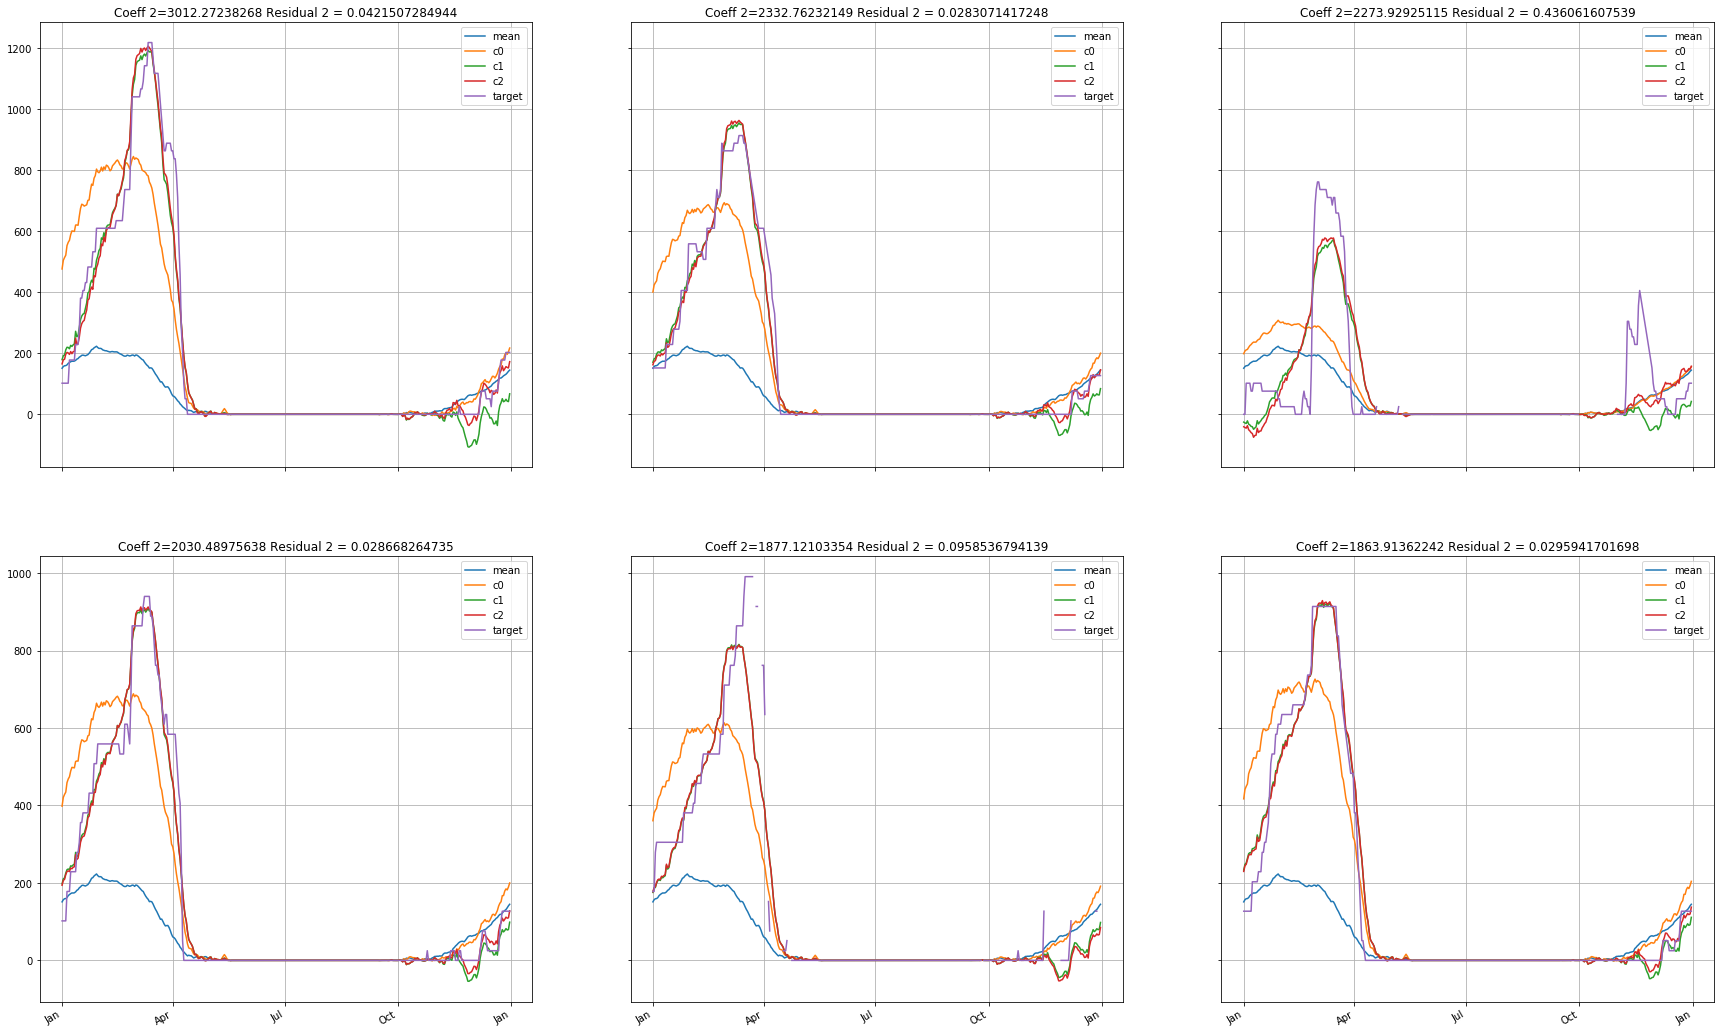

In [54]:
df8 = df3.sort(df3.coeff_2,ascending = False)
rows_c2 = df8.take(6)
df8.select('coeff_2','res_2').show(4)

plot_recon_grid(rows_c2,2,row_n=2,column_n=3,figsize=[30,20])

+-------------------+-------------------+
|            coeff_2|              res_2|
+-------------------+-------------------+
|-2474.3438377633706|0.15226203263922217|
|-2131.9917424015266| 0.0972204523308136|
|-2113.1698142716014| 0.7034477610240614|
|-2038.9515394964449|0.37218331706527996|
+-------------------+-------------------+
only showing top 4 rows



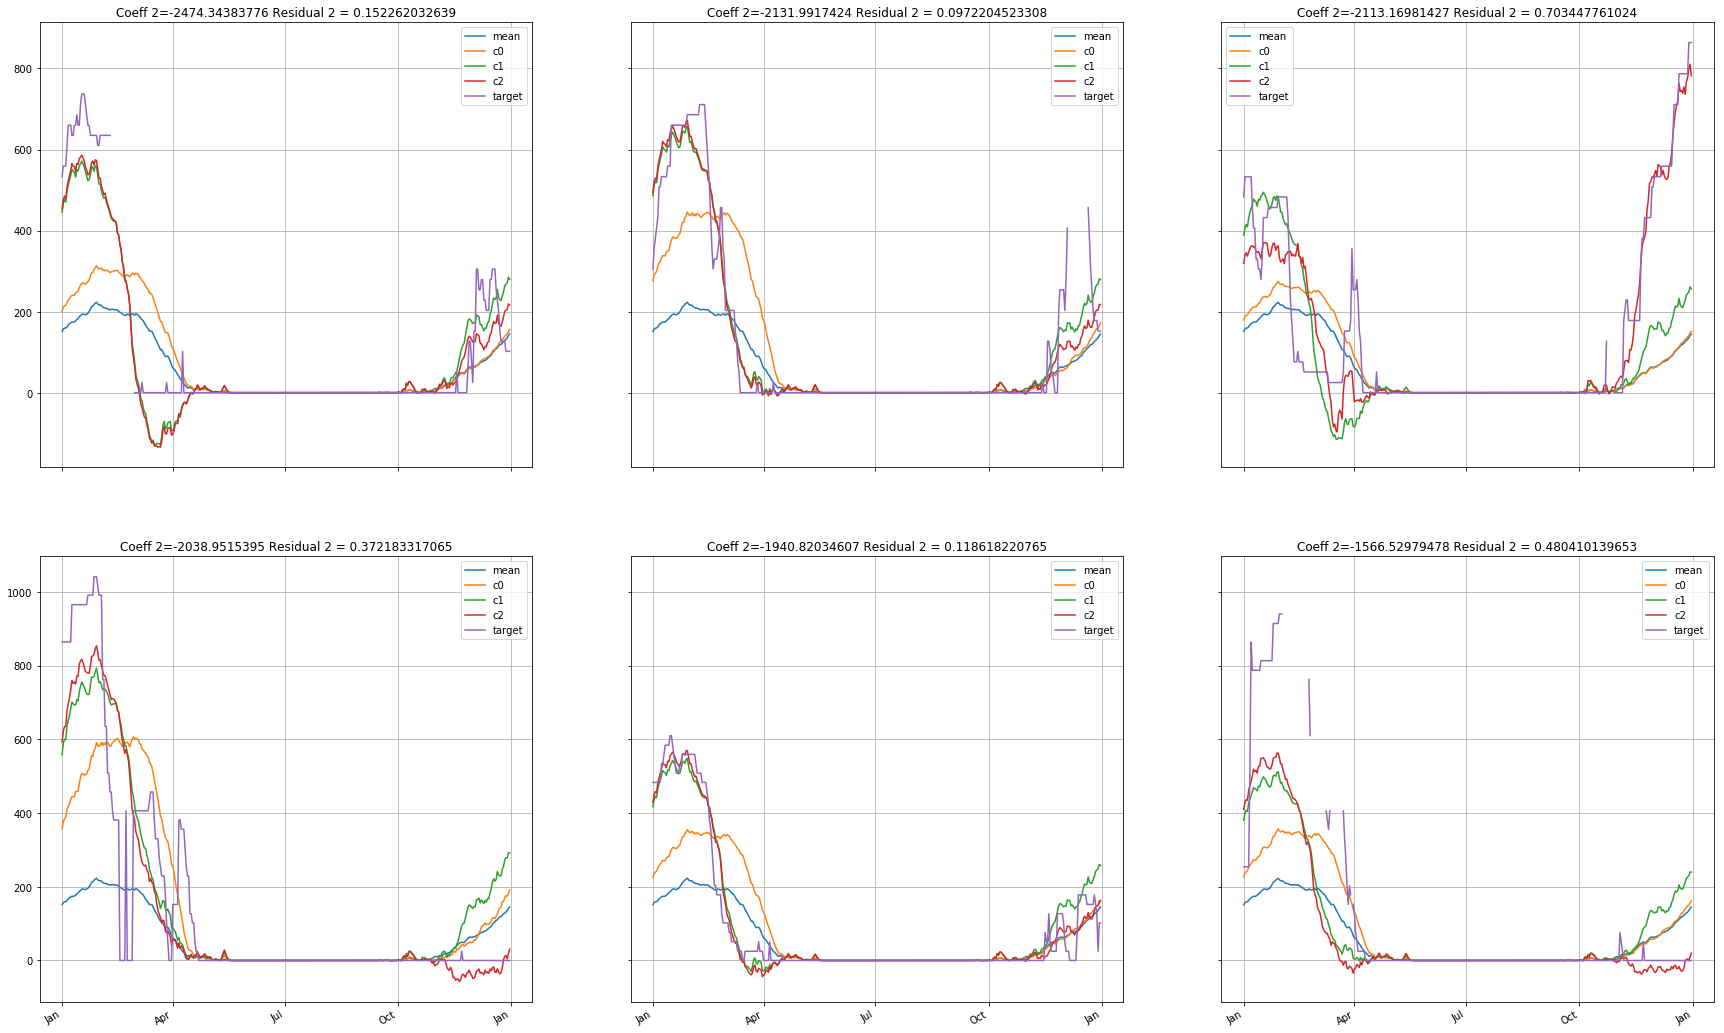

In [66]:
df11 = df3.sort(df3.coeff_2)
rows_c2_asc = df11.take(6)
df11.select('coeff_2','res_2').show(4)

plot_recon_grid(rows_c2_asc,2,row_n=2,column_n=3,figsize=[30,20])

+------------------+-------------------+
|           coeff_3|              res_3|
+------------------+-------------------+
|-2935.077017571062|0.15717216455964197|
|-2693.783709217654|0.11743997702225276|
|-2079.098947412651|0.14212439286543407|
|-2067.719756421644|0.13601152394455943|
+------------------+-------------------+
only showing top 4 rows



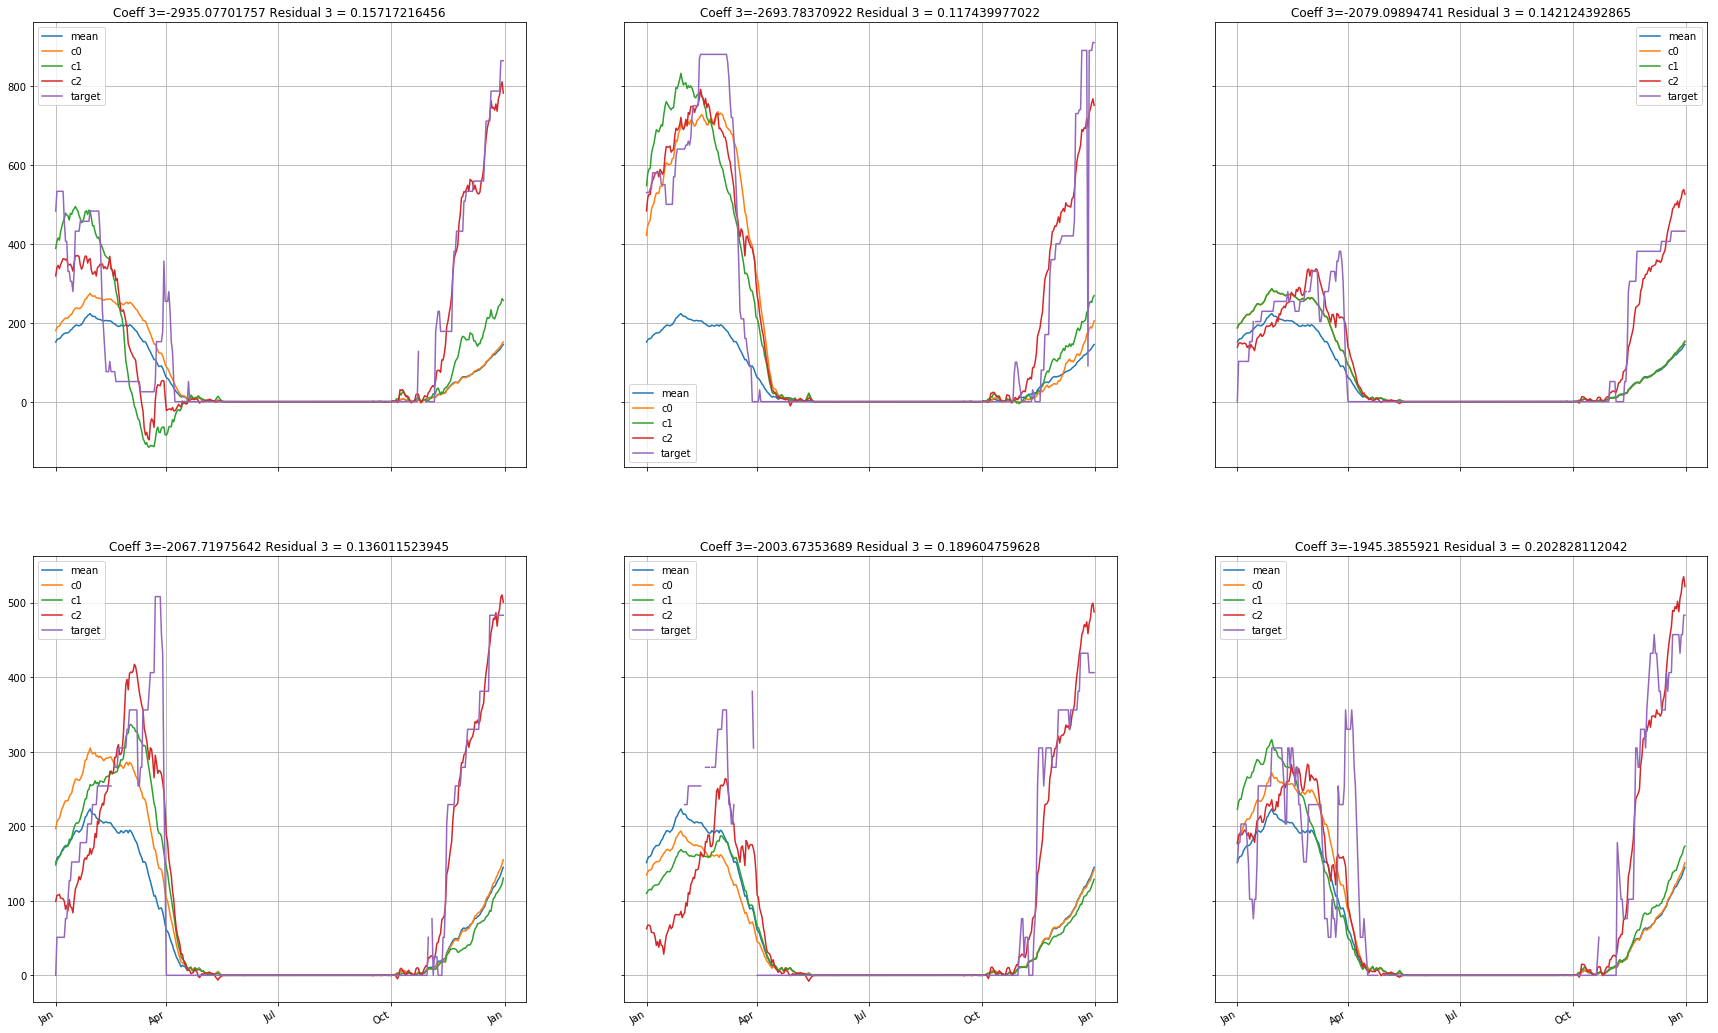

In [55]:
df9 = df3.sort(df3.coeff_3)
rows_c3_asc = df9.take(6)
df9.select('coeff_3','res_3').show(4)

plot_recon_grid(rows_c3_asc,3,row_n=2,column_n=3,figsize=[30,20])

+-------------------+-------------------+
|            coeff_2|              res_2|
+-------------------+-------------------+
|-2038.9515394964449|0.37218331706527996|
|-1566.5297947805625| 0.4804101396534344|
|-1482.7141478028989| 0.1858805642865061|
| -933.3252630546692|0.15902655719928585|
+-------------------+-------------------+
only showing top 4 rows



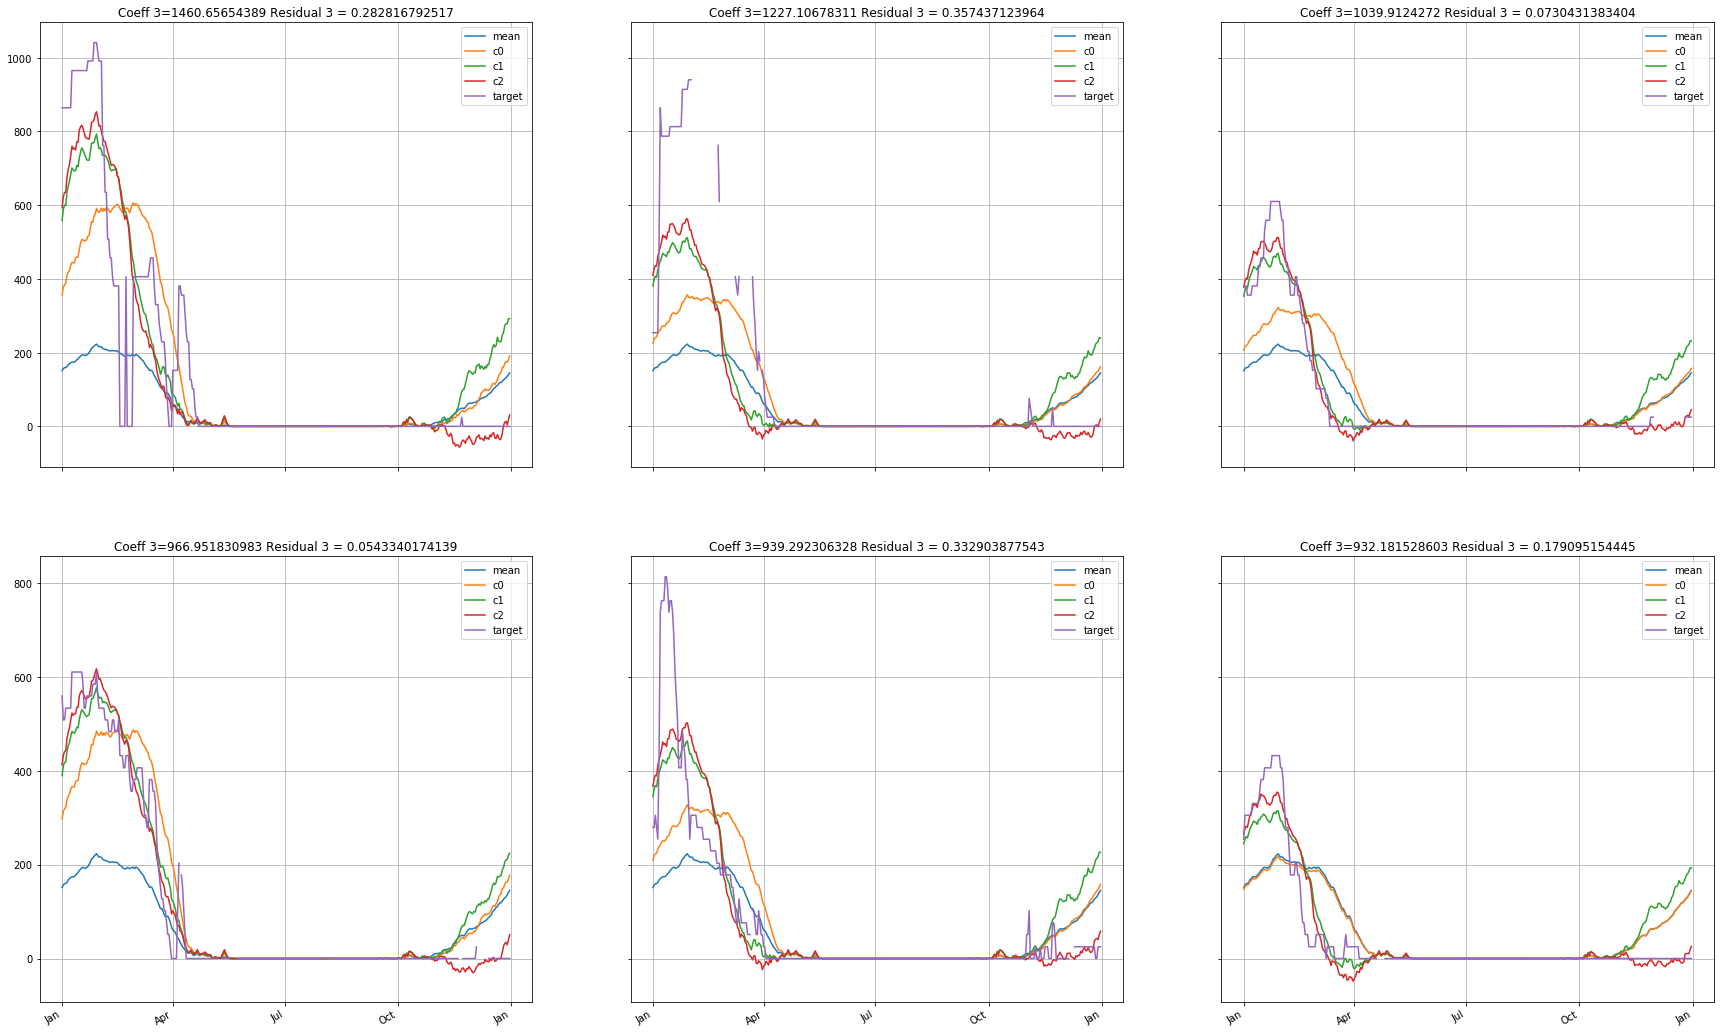

In [57]:
df10 = df3.sort(df3.coeff_3,ascending = False)
rows_c2 = df10.take(6)
df10.select('coeff_2','res_2').show(4)

plot_recon_grid(rows_c2,3,row_n=2,column_n=3,figsize=[30,20])

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.667030762563
residual normalized norm  after mean + top eigs: [ 0.28279683  0.04215073  0.03293663]


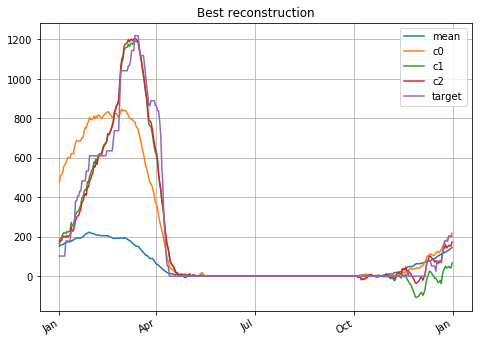

The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


In [68]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [68]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)+1))
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

In [77]:
feat = 'res_2'
rows=df3.select(feat).sort(feat).collect()
vals=[r[feat] for r in rows]


In [77]:
len(vals)

798

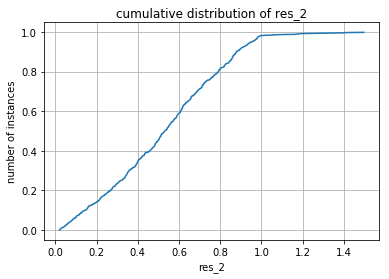

In [79]:
plot_CDF('res_2')

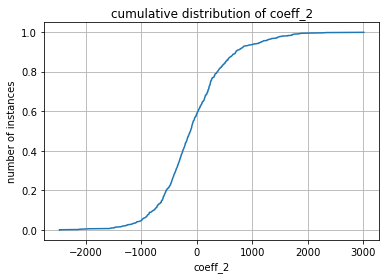

In [80]:
plot_CDF('coeff_2')

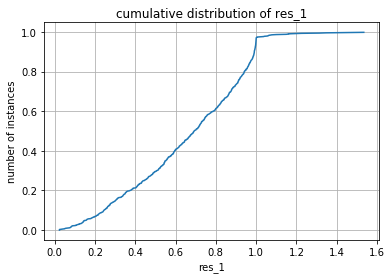

In [69]:
plot_CDF('res_1')

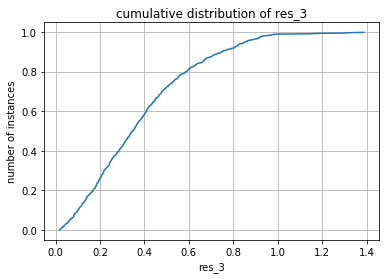

In [70]:
plot_CDF('res_3')

In [25]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
#!rm -rf $filename
#df3.write.parquet(filename)

In [24]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
3.9M	../../Data/Weather/decon_BBBSBBBB_PRCP.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet


In [58]:
gmap.draw("mymap.html")

NameError: name 'gmap' is not defined

In [76]:
sqlContext.registerDataFrameAsTable(df_in,'weather')
feat = 'res_2'
Query = "SELECT latitude,longitude,coeff_1,coeff_2,coeff_3 FROM weather ORDER BY latitude"
rows_geog = sqlContext.sql(Query).collect()
#vals=[r[feat] for r in rows]

AnalysisException: u"cannot resolve '`coeff_1`' given input columns: [elevation, longitude, vector, measurement, latitude, year, label, undefs, station]; line 1 pos 26;\n'Sort ['latitude ASC NULLS FIRST], true\n+- 'Project [latitude#255, longitude#256, 'coeff_1, 'coeff_2, 'coeff_3]\n   +- SubqueryAlias weather, `weather`\n      +- Relation[elevation#254,latitude#255,longitude#256,measurement#257,station#258,undefs#259L,vector#260,year#261,label#262] parquet\n"

In [84]:
def plot_CDF(feat1,feat2,feat3):
    rows1=df3.select(feat1).sort(feat1).collect()
    vals1=[r[feat1] for r in rows1]
    P1=np.arange(0,1,1./(len(vals1)+1))
    vals1=[vals1[0]]+vals1
    rows2=df3.select(feat2).sort(feat2).collect()
    vals2=[r[feat2] for r in rows2]
    vals2=[vals2[0]]+vals2
    P2=np.arange(0,1,1./(len(vals2)))
    rows3=df3.select(feat3).sort(feat3).collect()
    vals3=[r[feat3] for r in rows3]
    vals3=[vals3[0]]+vals3
    P3=np.arange(0,1,1./(len(vals3)))
    plot(vals1,P1,label=str(feat1))
    plot(vals2,P2,label=str(feat2))
    plot(vals3,P3,label=str(feat3))
    title('cumulative distribution of '+str(feat1)+" "+str(feat2)+" "+str(feat3))
    ylabel('number of instances')
    xlabel('coefficient')
    legend()
    grid()

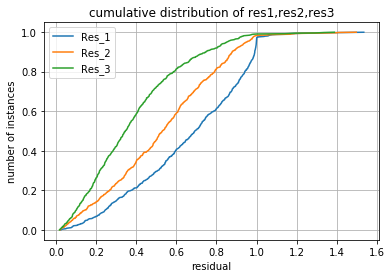

In [79]:
plot_CDF('res_1','res_2','res_3')

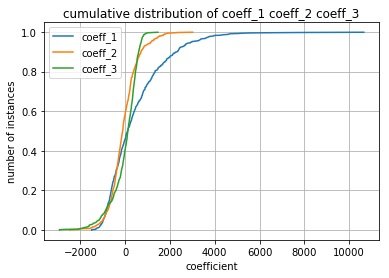

In [85]:
plot_CDF('coeff_1','coeff_2','coeff_3')